# Compare mmcq-numba & mmcq & kmeans by  scikit-learn

In [1]:
import cv2
import collections
import numpy as np
import time
from tqdm import tqdm as tqdm
from PIL import Image
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from mmcq_numba.quantize import mmcq
from mmcq.quantize import mmcq as mmcq_origin
from util_func import color2tile
%matplotlib inline

### params

In [2]:
color_count = 15
quantize = 5
path = "images/fall-g166eec8e3_1920.jpg"

## mmcq-numba test

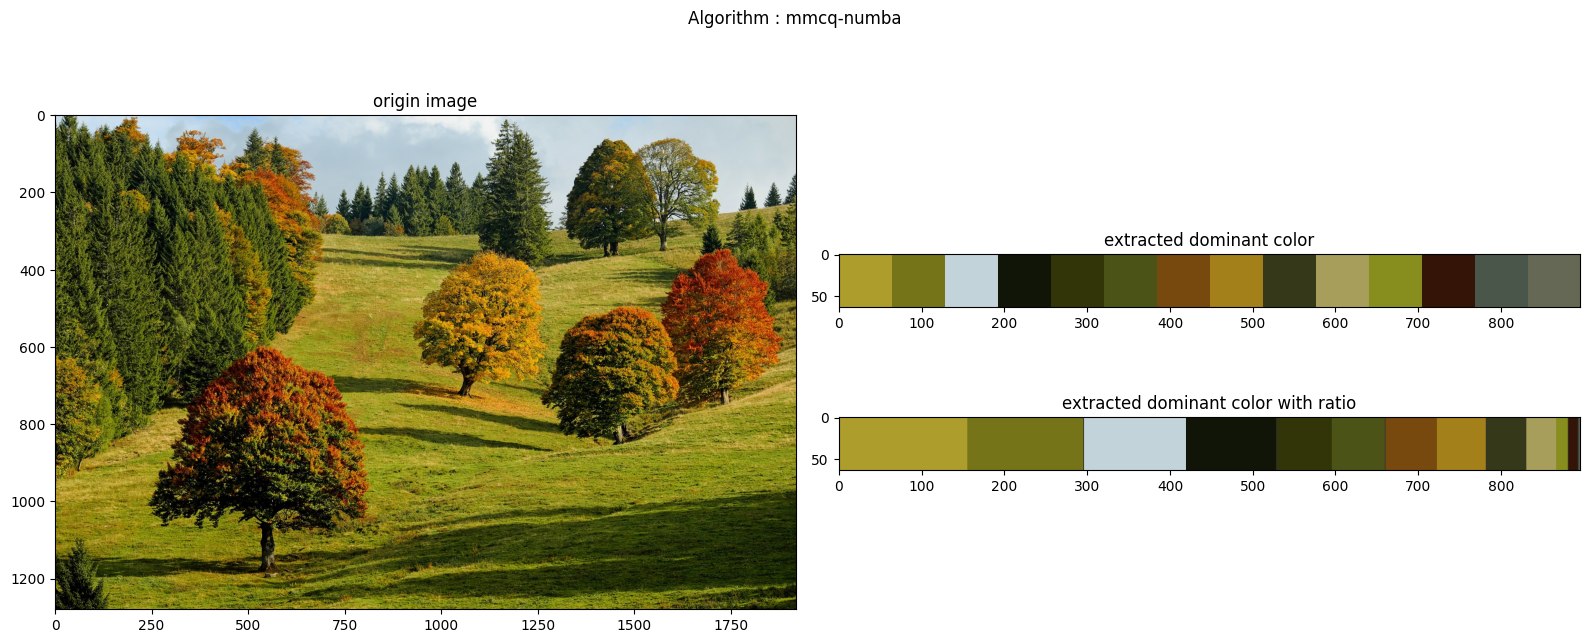

In [3]:
rgb = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
width,height,c = rgb.shape
rgb_resize = cv2.resize(rgb, (width//quantize, height//quantize))
width,height,c = rgb_resize.shape
colors = rgb_resize.reshape(width*height, c).astype(np.int64)

c_map = mmcq(colors, color_count)
color_info = [[info["vbox"]._count, info["color"]] for info in sorted(c_map.vboxes, key=lambda x:x['vbox']._count, reverse=True)]

figure = plt.figure(figsize=(16, 7))
plt.suptitle("Algorithm : mmcq-numba")
gs_master = GridSpec(nrows=4, ncols=2, height_ratios=[1, 1, 1, 1])

gs_1 = GridSpecFromSubplotSpec(nrows=4, ncols=1, subplot_spec=gs_master[:, 0])
axes_1 = figure.add_subplot(gs_1[:, :])
axes_1.set_title("origin image")
axes_1.imshow(rgb)

gs_2_and_3 = GridSpecFromSubplotSpec(nrows=4, ncols=1, subplot_spec=gs_master[:, 1])
axes_2 = figure.add_subplot(gs_2_and_3[1, :])
axes_2.set_title("extracted dominant color")
axes_2.imshow(color2tile(color_info, ratio="equal"))
axes_3 = figure.add_subplot(gs_2_and_3[2, :])
axes_3.set_title("extracted dominant color with ratio")
axes_3.imshow(color2tile(color_info, ratio="ratio"))
plt.tight_layout()
plt.show()

## Compare 3 algorithm

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.80it/s]


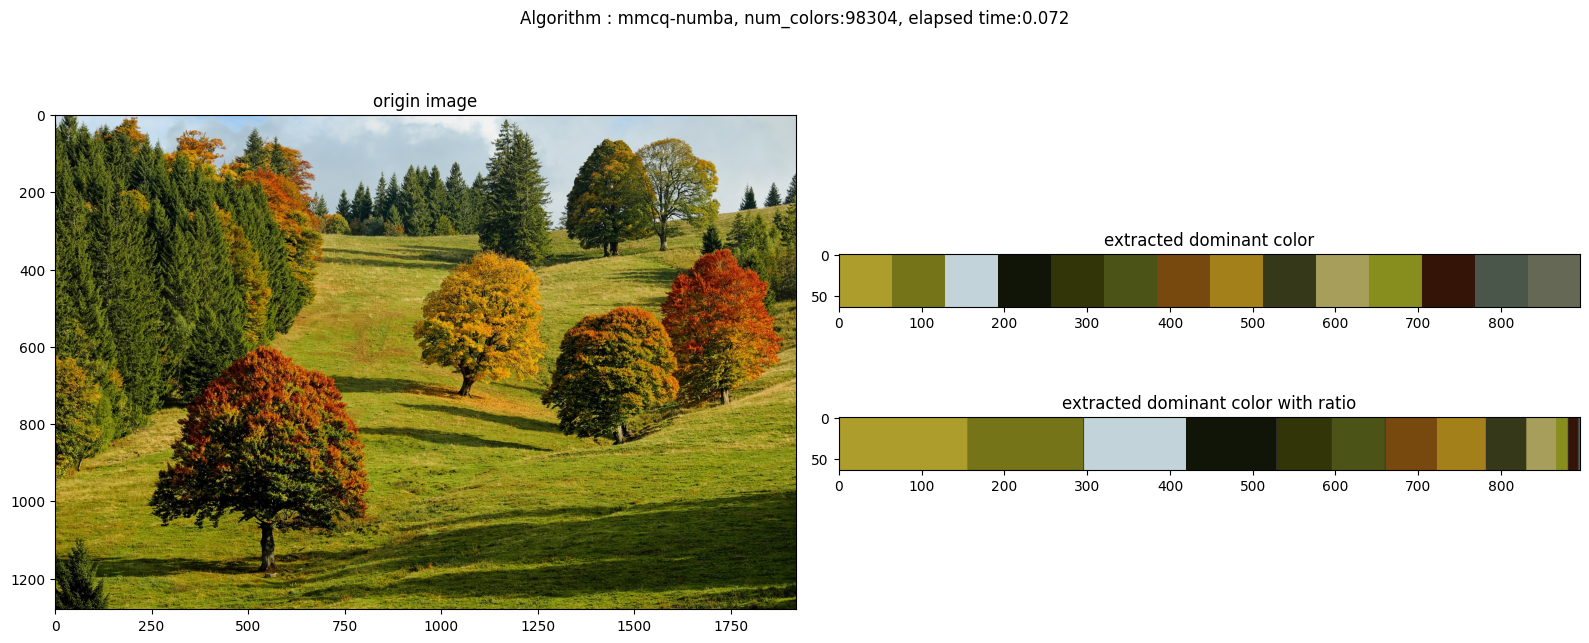

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.78it/s]


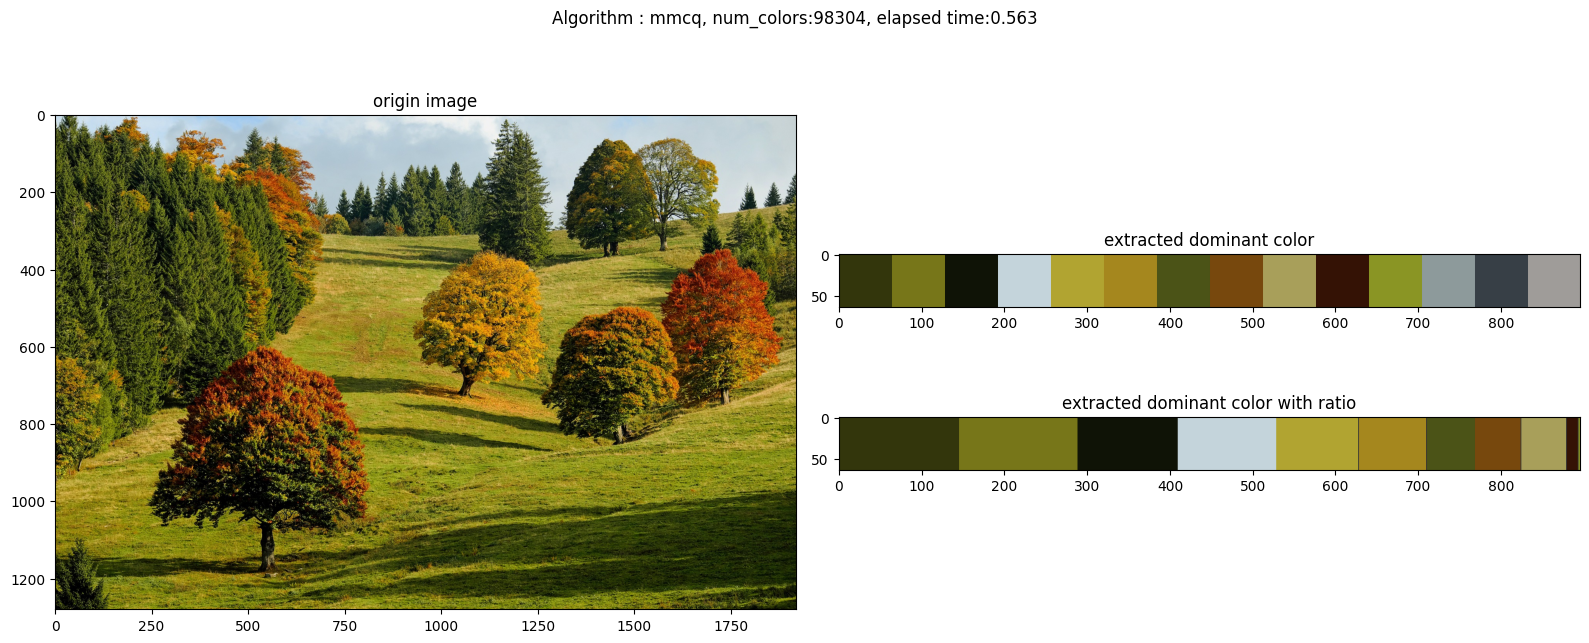

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.65it/s]


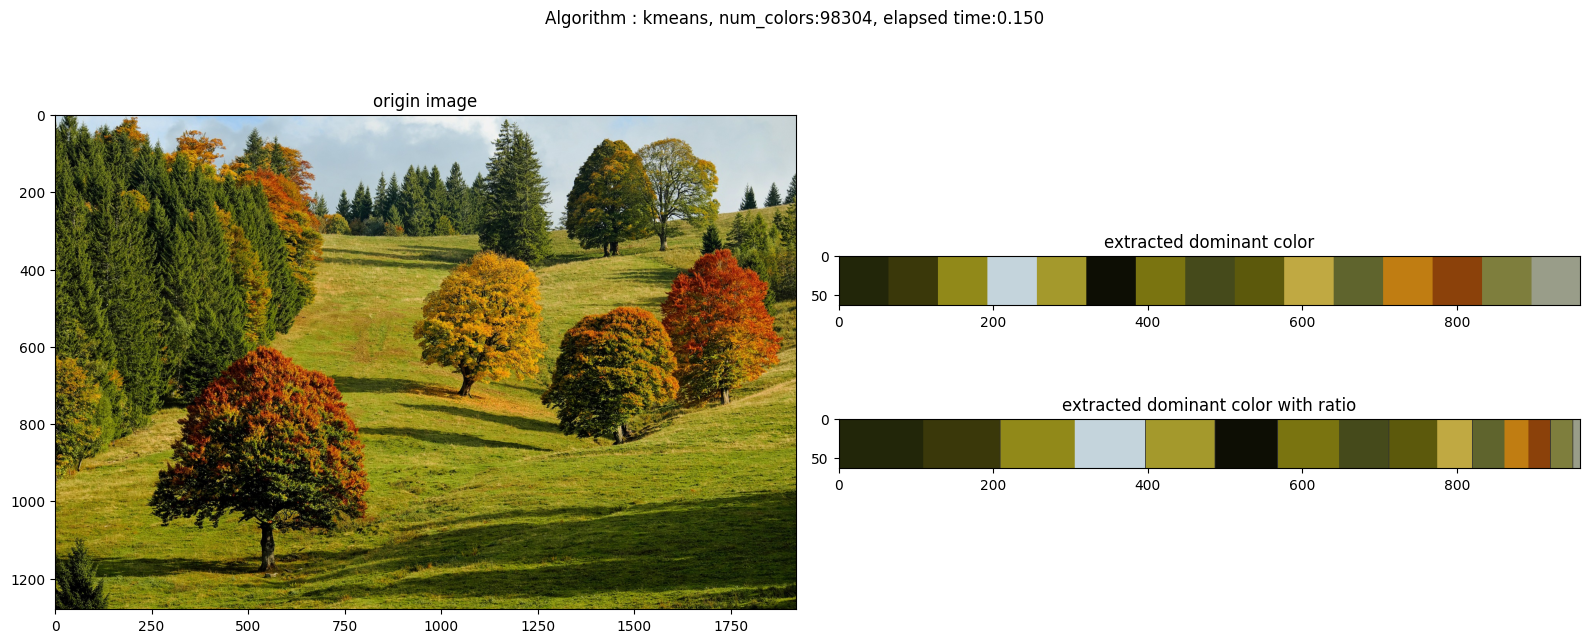

In [4]:
for algo_type in ["mmcq-numba","mmcq","kmeans"]:
    times = []
    for _ in tqdm(range(20)):
        start = time.time()
        if algo_type == "mmcq-numba":
            rgb = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
            width,height,c = rgb.shape
            rgb_resize = cv2.resize(rgb, (width//quantize, height//quantize))
            width,height,c = rgb_resize.shape
            colors = rgb_resize.reshape(width*height, c).astype(np.int64)

            c_map = mmcq(colors, color_count)
            color_info = [[info["vbox"]._count, info["color"]] for info in sorted(c_map.vboxes, key=lambda x:x['vbox']._count, reverse=True)]
        elif algo_type == "mmcq":
            sample = Image.open(path)
            rgb = sample.convert('RGB')

            colors = []
            for x in range(0, rgb.width, quantize):
                for y in range(0, rgb.height, quantize):
                    rgb_color = rgb.getpixel((x, y))
                    colors.append(rgb_color)
            c_map = mmcq_origin(colors, color_count)
            color_info = [[info["vbox"]._count, info["color"]] for info in sorted(c_map.vboxes, key=lambda x:x['vbox']._count, reverse=True)]
        elif algo_type == "kmeans":
            rgb = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)
            width,height,c = rgb.shape
            rgb_resize = cv2.resize(rgb, (width//quantize, height//quantize))
            width,height,c = rgb_resize.shape
            colors = rgb_resize.reshape(width*height, c).astype(np.int64)
            kmeans = KMeans(
                n_clusters = color_count,
                random_state=0,
                n_init="auto"
            )

            color_labels = kmeans.fit_predict(colors)
            center_colors=kmeans.cluster_centers_

            counts = collections.Counter(color_labels).most_common()
            ordered_colors = [center_colors[i[0]].astype(np.int64) for i in counts]
            color_info = [[count[1], color] for count, color in zip(counts, ordered_colors)]
            
        times.append(time.time()-start)
        
    figure = plt.figure(figsize=(16, 7))
    plt.suptitle(f"Algorithm : {algo_type}, num_colors:{len(colors)}, elapsed time:{np.mean(times):.3f}")
    gs_master = GridSpec(nrows=4, ncols=2, height_ratios=[1, 1, 1, 1])

    gs_1 = GridSpecFromSubplotSpec(nrows=4, ncols=1, subplot_spec=gs_master[:, 0])
    axes_1 = figure.add_subplot(gs_1[:, :])
    axes_1.set_title("origin image")
    axes_1.imshow(rgb)

    gs_2_and_3 = GridSpecFromSubplotSpec(nrows=4, ncols=1, subplot_spec=gs_master[:, 1])
    axes_2 = figure.add_subplot(gs_2_and_3[1, :])
    axes_2.set_title("extracted dominant color")
    axes_2.imshow(color2tile(color_info, ratio="equal"))
    axes_3 = figure.add_subplot(gs_2_and_3[2, :])
    axes_3.set_title("extracted dominant color with ratio")
    axes_3.imshow(color2tile(color_info, ratio="ratio"))
    plt.tight_layout()
    plt.show()